# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [112]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report, precision_recall_fscore_support, confusion_matrix, make_scorer

pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

In [113]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [114]:
def load_and_preprocess_data(path):
    
    df = spark.read.json(path).toPandas()
    
    # Drop null user IDs and guest user sessions, then convert userID to correct data type
    df = df[(df['userId'] != '') & (df['auth'] != 'Guest')]
    
    # Convert timestamp to date and time, then create time variables
    df['ts2'] = pd.to_datetime(df.ts, unit='ms')
    df['month'] = df['ts2'].dt.month
    df['day'] = df['ts2'].dt.day
    df['time'] = df['ts2'].dt.time
    df['weekday'] = df['ts2'].dt.dayofweek
    df['week'] = df['ts2'].dt.week
    
    return df

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [115]:
def flag_churn(df):
    # Get all unique IDs associated with a cancellation confirmation page
    churned_ids = list(df.loc[df['page'] == 'Cancellation Confirmation']['userId'].unique())
    df['churn'] = df['userId'].map(lambda user: 1 if user in churned_ids else 0)
    
    #downgraded_ids = list(df.loc[df['page'] == 'Downgrade']['userId'].unique())
    #df['downgraded'] = df['userId'].map(lambda user: 1 if user in downgraded_ids else 0)
    
    # Create downgraded and churned flag
    #users_both = list(df.loc[(df['churn'] == 1) & (df['downgraded'] == 1)].drop_duplicates(subset = 'userId')['userId'].unique())
    #df['c_and_d'] = df['userId'].map(lambda user: 1 if user in users_both else 0)

    # Create downgraded only flag
    #users_downgrade_only = list(df.loc[(df['churn'] == 0) & (df['downgraded'] == 1)].drop_duplicates(subset = 'userId')['userId'].unique())
    #df['downgrade_only'] = df['userId'].map(lambda user: 1 if user in users_downgrade_only else 0)

    # Create churned only flag
    #users_churn_only = list(df.loc[(df['churn'] == 1) & (df['downgraded'] == 0)].drop_duplicates(subset = 'userId')['userId'].unique())
    #df['churn_only'] = df['userId'].map(lambda user: 1 if user in users_churn_only else 0)
    
    return df

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [149]:
def engineer_features(df):
    # Calculate total unique songs and artists listened to per user
    df_agg_unique_listens = df.groupby('userId')['artist','song'].nunique() \
                            .rename(columns = {'artist': 'n_artist_total', 'song': 'n_song_total'})
    
    # Find total songs listened to overall per user
    df_agg_total_listens = pd.DataFrame(df.groupby('userId')['song'].count() \
                                        .rename(columns = {'song': 'total_listens'})) \
                                        .reset_index() \
                                        .rename(columns = {'index': 'userId', 0: 'total_songs'})
    
    # Get other aggregate statistics at the user level
    df_agg = df.groupby('userId')['gender','length','location','ts2','churn'] \
                .max().rename(columns = {'ts2': 'max_date'})
    
    # Merge into 1 dataset
    df_agg_2 = df_agg.merge(df_agg_unique_listens, on = 'userId')
    df_agg_2 = df_agg_2.merge(df_agg_total_listens, on = 'userId')
    
    # Create weekly averages
    df_unique_listens_wk = df.groupby(['userId','week'])['artist','song'].nunique()
    df_unique_listens_wk = df_unique_listens_wk.groupby(['userId'])['artist','song'] \
                            .mean().rename(columns = {'artist': 'n_artist_wk_avg', 'song': 'n_song_wk_avg'})
    
    df_total_listens_wk = pd.DataFrame(df.groupby(['userId','week'])['song'].count()).reset_index()
    df_total_listens_wk = df_total_listens_wk.groupby(['userId'])['song'] \
                                                .mean().reset_index().rename(columns = {'song': 'total_songs_wk_avg'})
    
    # Add to overall dataframe
    df_agg_2 = df_agg_2.merge(df_unique_listens_wk, on = 'userId')
    df_agg_2 = df_agg_2.merge(df_total_listens_wk, on = 'userId')
    
    # Calculate % of interactions per user per page type
    user_page_totals = df[df['page'] != 'NextSong'].groupby(['userId','page'])['page'].count()
    user_total_interactions = df[df['page'] != 'NextSong'].groupby(['userId'])['page'].count()
    
    # Calculate percentage engaged with per user per page overall
    user_pct_page_ix = (user_page_totals / user_total_interactions * 100).rename('pct')

    user_pct_page_ix = pd.DataFrame(user_pct_page_ix)

    # Pivot so each row represents 1 user and their percentages
    user_pct_page_ix = pd.pivot_table(user_pct_page_ix, values = ['pct'], index = ['userId'], columns = ['page']) \
                        .reset_index().fillna(0)

    # Clean column names and return object
    user_pct_page_ix.columns = ["_".join((j,k)) for j,k in user_pct_page_ix.columns]
    user_pct_page_ix.columns = [j.lower() for j in user_pct_page_ix.columns]
    user_pct_page_ix.columns = [j.replace(' ','_') for j in user_pct_page_ix.columns]
    user_pct_page_ix = user_pct_page_ix.rename(columns = {'userid_': 'userId'})
    
    # Join as columns on userId to original df
    df_merged = df_agg_2.merge(user_pct_page_ix, on = 'userId')

    # Truncate location to state level only
    df_merged['location'] = df_merged['location'].str[-2:]
    
    # Find total page visits per type per user
    total_visits_df = df.groupby(['userId','page'])['page'].count().rename('total_visits').reset_index()
    total_visits_df = pd.pivot_table(total_visits_df, values = ['total_visits'], index = ['userId'], columns = ['page']) \
                        .reset_index().fillna(0)

    # Clean column names and return object
    total_visits_df.columns = ["_".join((j,k)) for j,k in total_visits_df.columns]
    total_visits_df.columns = [j.lower() for j in total_visits_df.columns]
    total_visits_df.columns = [j.replace(' ','_') for j in total_visits_df.columns]
    total_visits_df = total_visits_df.rename(columns = {'userid_': 'userId'})
    
    # Merge and create ratio columns
    df_merged = df_merged.merge(total_visits_df, on = 'userId')
    df_merged['likes_to_plays_ratio'] = df_merged['total_visits_thumbs_up'] / df_merged['total_songs']
    df_merged['dislikes_to_plays_ratio'] = df_merged['total_visits_thumbs_down'] / df_merged['total_songs']
    df_merged['ads_to_plays_ratio'] = df_merged['total_visits_roll_advert'] / df_merged['total_songs']
    
    return df_merged

### Create Pipeline

In [166]:
def prep_for_modeling(df):
    
    # Drop columns not needed for modeling
    df = df.drop(['max_date', 'userId', 'location', 'pct_cancel', 'pct_cancellation_confirmation', 'pct_submit_downgrade', \
                  'n_song_total', 'n_artist_total', 'total_songs', 'pct_help', 'pct_error', 'pct_upgrade', 'pct_submit_upgrade', \
                  'pct_save_settings', 'gender', 'total_visits_about','total_visits_add_friend','total_visits_add_to_playlist','total_visits_cancel', \
                    'total_visits_cancellation_confirmation','total_visits_downgrade','total_visits_error','total_visits_help', \
                    'total_visits_home','total_visits_logout','total_visits_nextsong','total_visits_roll_advert', 'pct_logout', 'total_visits_settings', \
                    'total_visits_save_settings','total_visits_submit_downgrade','total_visits_submit_upgrade','total_visits_thumbs_down', \
                    'total_visits_thumbs_up','total_visits_upgrade'], axis = 1)
    
    # Separate X and Y
    y = pd.DataFrame(df['churn'])
    modeling_cols = [x for x in df.columns if x not in y.columns]
    X = df[modeling_cols]
    
    # Encode categoricals
    #X = pd.get_dummies(X, drop_first = True, dummy_na=False)

    # Normalize
    X_2 = Normalizer().fit_transform(X)
    X_2 = pd.DataFrame(X_2, columns = X.columns)

    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size = 0.3, random_state = 42)
    
    return df, X_train, X_test, y_train, y_test

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [167]:
# Build evaluation function
def __evaluate_model(y_test, y_preds):
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, average = 'weighted')
    recall = recall_score(y_test, y_preds, average = 'weighted')
    f1 = f1_score(y_test, y_preds, average = 'weighted')
    auc = roc_auc_score(y_test, y_preds, average = 'weighted')
    
    return accuracy, precision, recall, f1, auc

In [168]:
def __get_feature_importance(model):

    importances = model.feature_importances_
    names = [i for i in X_train.columns]

    imp_df = pd.DataFrame(importances, names).reset_index() \
                    .rename(columns = {'index': 'Variable', 0: 'Importance'}) \
                    .sort_values(by = 'Importance', ascending = False)

    return imp_df

### Logistic Regression

In [105]:
def get_logistic_model(X_train, y_train, X_test):

    # Create modeling object
    model = LogisticRegression(random_state = 42)
    params = model.get_params

    # Fit model
    model.fit(X_train, y_train)

    # Predict using model
    y_preds = model.predict(X_test)

    # Evaluate
    accuracy, precision, recall, f1, auc = __evaluate_model(y_test, y_preds)
    
    return params, accuracy, precision, recall, f1, auc

### Random Forest Classifier

In [106]:
def get_rf_model(X_train, y_train, X_test):
    
    # Create modeling object
    model = RandomForestClassifier(random_state = 42, max_depth = 10, max_leaf_nodes = 7)
    params = model.get_params

    # Fit model
    model.fit(X_train, y_train)

    # Predict using model
    y_preds = model.predict(X_test)

    # Evaluate
    accuracy, precision, recall, f1, auc = __evaluate_model(y_test, y_preds)
    
    
    # Feature Importance plot
    imp_df = __get_feature_importance(model)
    
    return params, accuracy, precision, recall, f1, auc, imp_df

### Gradient Boosted Classifier

In [107]:
def get_gb_model(X_train, y_train, X_test):

    # Make scorer
    #f1_scorer = make_scores(__get_scores

    # Create modeling object
    model = GradientBoostingClassifier(random_state = 42, max_features = 7, max_leaf_nodes = 5) #GridSearchCV(pipeline, param_grid = parameters, scoring = f1_scorer)
    params = model.get_params

    # Fit model
    model.fit(X_train, y_train)

    # Predict using model
    y_preds = model.predict(X_test)

    # Evaluate
    accuracy, precision, recall, f1, auc = __evaluate_model(y_test, y_preds)

    # Feature Importance plot
    imp_df = __get_feature_importance(model)

    return params, accuracy, precision, recall, f1, auc, imp_df

### Run Pipeline

In [169]:
path = 'mini_sparkify_event_data.json'

df = load_and_preprocess_data(path)
df = flag_churn(df)
df = engineer_features(df)

df.head()

,userId,gender,length,location,max_date,churn,n_artist_total,n_song_total,total_songs,n_artist_wk_avg,n_song_wk_avg,total_songs_wk_avg,pct_about,pct_add_friend,pct_add_to_playlist,pct_cancel,pct_cancellation_confirmation,pct_downgrade,pct_error,pct_help,pct_home,pct_logout,pct_roll_advert,pct_save_settings,pct_settings,pct_submit_downgrade,pct_submit_upgrade,pct_thumbs_down,pct_thumbs_up,pct_upgrade,total_visits_about,total_visits_add_friend,total_visits_add_to_playlist,total_visits_cancel,total_visits_cancellation_confirmation,total_visits_downgrade,total_visits_error,total_visits_help,total_visits_home,total_visits_logout,total_visits_nextsong,total_visits_roll_advert,total_visits_save_settings,total_visits_settings,total_visits_submit_downgrade,total_visits_submit_upgrade,total_visits_thumbs_down,total_visits_thumbs_up,total_visits_upgrade,likes_to_plays_ratio,dislikes_to_plays_ratio,ads_to_plays_ratio,add_friend_to_plays_ratio
0,10,M,978.44200,MS,2018-11-19 12:49:48,0,565,629,673,125.000000,131.8,134.60,1.639344,9.836066,7.377049,0.000000,0.000000,5.737705,0.000000,0.819672,24.590164,9.016393,0.819672,0.819672,5.737705,0.00000,0.00000,3.278689,30.327869,0.000000,2.0,12.0,9.0,0.0,0.0,7.0,0.0,1.0,30.0,11.0,673.0,1.0,1.0,7.0,0.0,0.0,4.0,37.0,0.0,0.054978,0.005944,0.001486,0.017831
1,100,M,2520.99873,TX,2018-11-30 14:15:49,0,1705,2302,2682,266.555556,288.0,298.00,2.255639,9.210526,11.466165,0.000000,0.000000,5.639098,0.563910,3.383459,19.736842,6.578947,4.699248,0.939850,2.067669,0.18797,0.18797,5.075188,27.819549,0.187970,12.0,49.0,61.0,0.0,0.0,30.0,3.0,18.0,105.0,35.0,2682.0,25.0,5.0,11.0,1.0,1.0,27.0,148.0,1.0,0.055183,0.010067,0.009321,0.018270
2,100001,F,655.77751,FL,2018-10-02 16:36:45,1,125,129,133,125.000000,129.0,133.00,0.000000,3.703704,5.555556,1.851852,1.851852,0.000000,1.851852,1.851852,20.370370,12.962963,25.925926,0.000000,1.851852,0.00000,0.00000,3.703704,14.814815,3.703704,0.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,11.0,7.0,133.0,14.0,0.0,1.0,0.0,0.0,2.0,8.0,2.0,0.060150,0.015038,0.105263,0.015038
3,100002,F,732.39465,CA,2018-12-03 01:11:16,0,184,193,195,46.500000,48.5,48.75,0.000000,4.347826,21.739130,0.000000,0.000000,8.695652,0.000000,0.000000,26.086957,4.347826,13.043478,0.000000,0.000000,0.00000,0.00000,0.000000,21.739130,0.000000,0.0,1.0,5.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,195.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.025641,0.000000,0.015385,0.005128
4,100003,F,636.78649,FL,2018-10-11 16:19:41,1,50,51,51,50.000000,51.0,51.00,0.000000,0.000000,7.407407,3.703704,3.703704,0.000000,0.000000,3.703704,25.925926,11.111111,33.333333,0.000000,0.000000,0.00000,0.00000,0.000000,11.111111,0.000000,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,7.0,3.0,51.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.058824,0.000000,0.176471,0.000000


In [173]:
df, X_train, X_test, y_train, y_test = prep_for_modeling(df)
params, accuracy, precision, recall, f1, auc = get_logistic_model(X_train, y_train, X_test)

print('Logistic Regrssion Parameters:', params)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Logistic Regrssion Parameters: <bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>
Accuracy: 0.794117647059
Precision: 0.63062283737
Recall: 0.794117647059
F1: 0.702989392478


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest Parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=7,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)>
Accuracy: 0.823529411765
Precision: 0.803676470588
Recall: 0.823529411765
F1: 0.80410920349


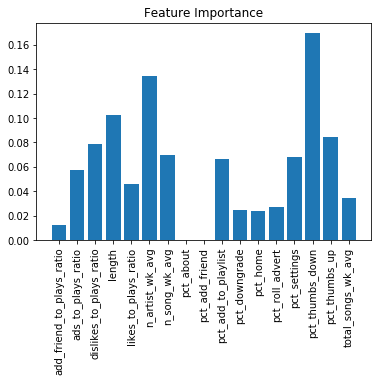

In [174]:
params, accuracy, precision, recall, f1, auc, imp_df = get_rf_model(X_train, y_train, X_test)

print('Random Forest Parameters:', params)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)


# Create plot
plt.figure()
plt.title("Feature Importance")
plt.bar(imp_df['Variable'], imp_df['Importance'])
plt.xticks(rotation=90)
plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB Classifier Parameters: <bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=7, max_leaf_nodes=5, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)>
Accuracy: 0.808823529412
Precision: 0.79496200394
Recall: 0.808823529412
F1: 0.799936406995


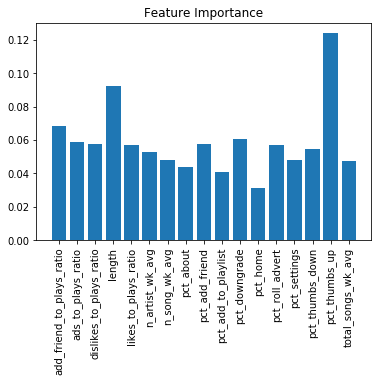

In [175]:
params, accuracy, precision, recall, f1, auc, imp_df = get_gb_model(X_train, y_train, X_test)

print('GB Classifier Parameters:', params)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)


# Create plot
plt.figure()
plt.title("Feature Importance")
plt.bar(imp_df['Variable'], imp_df['Importance'])
plt.xticks(rotation=90)
plt.show()